In [19]:
import numpy as np
import pandas as pd
import tmm

# imports and setup for tmm
from __future__ import division, print_function, absolute_import

from tmm import (coh_tmm, unpolarized_RT, ellips,
                       position_resolved, find_in_structure_with_inf)

from numpy import pi, linspace, inf, array
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline
import math

# "5 * degree" is 5 degrees expressed in radians
# "1.2 / degree" is 1.2 radians expressed in degrees
degree = pi/180

# Define imaginary dielectric function for a single Tauc-Lorentz Oscillator

In [20]:
def epsilon_i_TL(A,E_0,C,E_g,E):
    
    if E>E_g:
        epsilon_i_TL=(1/E)*(A*E_0*C)*(E-E_g)**2/((E**2-(E_0)**2)**2+C**2*E**2)
    else:
        epsilon_i_TL=0;
  
    return epsilon_i_TL

# Define real dielectric function for a single Tauc-Lorentz Oscillator

In [21]:
def epsilon_r_TL(A,E_0,C,E_g,E):
    a_ln=(E_g**2-E_0**2)*E**2+E_g**2*C**2-E_0**2*(E_0**2+3*E_g**2)
    a_a=(E**2-E_0**2)*(E_0**2+E_g**2)+E_g**2*C**2
    alpha=(4*E_0**2-C**2)**(1/2)
    gamma=(E_0**2-C**2/2)**(1/2)
    zeta_4=(E**2-gamma**2)**2+alpha**2*C**2/4
    
    epsilon_r_TL=((A*C*a_ln)/(2*pi*zeta_4*alpha*E_0))\
    *math.log((E_0**2+E_g**2+alpha*E_g)/(E_0**2+E_g**2-alpha*E_g))\
    -((A*a_a)/(pi*zeta_4*E_0))*(pi-math.atan((2*E_g+alpha)/C)\
    +math.atan((alpha-2*E_g)/C))\
    +(4*A*E_0*E_g*(E**2-gamma**2)/(pi*zeta_4*alpha))\
    *(math.atan((alpha+2*E_g)/C)+math.atan((alpha-2*E_g)/C))\
    -(A*E_0*C*(E**2+E_g**2)/(pi*zeta_4*E))*math.log(abs(E-E_g)/(E+E_g))\
    +((2*A*E_0*C)/(pi*zeta_4))*E_g\
    *math.log((abs(E-E_g)*(E+E_g))/((E_0**2-E_g**2)**2+E_g**2*C**2)**(1/2))
    
    return epsilon_r_TL

# Perovskite model with multiple Tauc-Lorentz oscillators
in this case the model consist on 5 Tauc-Lorentz oscillators, usually the band gap of the material will be the same (E_g) for all the oscillators but for a more general code here I label the E_g for each oscillator. 

In [22]:
def nk_perovskite(params):
    
    #the number of params depends on the number of oscilators, for N oscilators this is 4N+2
    
    params=A_1,E_0_1,C_1,E_g_1,\
           A_2,E_0_2,C_2,E_g_2,\
           A_3,E_0_3,C_3,E_g_3,\
           A_4,E_0_4,C_4,E_g_4,\
           A_5,E_0_5,C_5,E_g_5,\
           E, epsilon_inf
    
    #Define dielectric function for multiple oscillators this section will
    #be different for every material 
    
    epsilon_i=epsilon_i_TL(A_1,E_0_1,C_1,E_g_1,E)+\
              epsilon_i_TL(A_2,E_0_2,C_2,E_g_2,E)+\
              epsilon_i_TL(A_3,E_0_3,C_3,E_g_3,E)+\
              epsilon_i_TL(A_4,E_0_4,C_4,E_g_4,E)+\
              epsilon_i_TL(A_5,E_0_5,C_5,E_g_5,E)
    epsilon_r=epsilon_r_TL(A_1,E_0_1,C_1,E_g_1,E)+\
              epsilon_r_TL(A_2,E_0_2,C_2,E_g_2,E)+\
              epsilon_r_TL(A_3,E_0_3,C_3,E_g_3,E)+\
              epsilon_r_TL(A_4,E_0_4,C_4,E_g_4,E)+\
              epsilon_r_TL(A_5,E_0_5,C_5,E_g_5,E)+\
              epsilon_inf
    #calculate refractive index from dielectric constants. This section
    #will be the same for every materials as long as their dielectric
    #functions are called epsilon_i, epsilon_r
    
    epsilon_module=(epsilon_r**2+epsilon_i**2)**(1/2)
    n_perovskite=((epsilon_module+epsilon_r)/2)**(1/2)
    k_perovskite=((epsilon_module-epsilon_r)/2)**(1/2)
        
    nk_perovskite= complex(n_perovskite, k_perovskite)
    
    return nk_perovskite;

# Calculate optical constants for a range of wavelengths

In [31]:
#set initial parameters
A_1=48
A_2=7
A_3=6
A_4=9.5
A_5=3.3

E_0_1=4
E_0_2=1.9
E_0_3=2.53
E_0_4=3.33
E_0_5=6.4

C_1=7.05
C_2=0.35
C_3=0.5
C_4=0.77
C_5=3.3

E_g_1=1.56
E_g_2=1.56
E_g_3=1.56
E_g_4=1.56
E_g_5=1.56

epsilon_inf=0

n_perovskite=[]
k_perovskite=[]

#set wavelength range
lambda_list = linspace(300,1000,500) #in nm

# calculate opt
for lambda_vac in lambda_list:
    #convert wavelength to energy
    E=1240/lambda_vac
    params=A_1,E_0_1,C_1,E_g_1,\
       A_2,E_0_2,C_2,E_g_2,\
       A_3,E_0_3,C_3,E_g_3,\
       A_4,E_0_4,C_4,E_g_4,\
       A_5,E_0_5,C_5,E_g_5,\
       E, epsilon_inf
    n_perovskite.append(nk_perovskite(params).real)
    k_perovskite.append(nk_perovskite(params).imag)
    # angle in degrees

mod=pd.DataFrame({"n_material":n_perovskite,
                       "k_material":k_perovskite})

# Plot optical contants

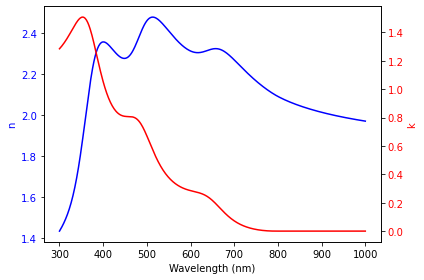

In [32]:
# plot nk
fig, ax1 = plt.subplots()

color = 'b'
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('n', color=color)
ax1.plot(lambda_list,n_perovskite, 'b-', markerfacecolor='none', ms=7, markeredgecolor='red')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'r'
ax2.set_ylabel('k', color=color)  # we already handled the x-label with ax1
ax2.plot(lambda_list , k_perovskite ,'r-', markerfacecolor='none', ms=7, markeredgecolor='blue')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()